In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data
from torch.utils.data import DataLoader 
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns
import wandb
import math
import argparse
import datetime
import math
from time import time

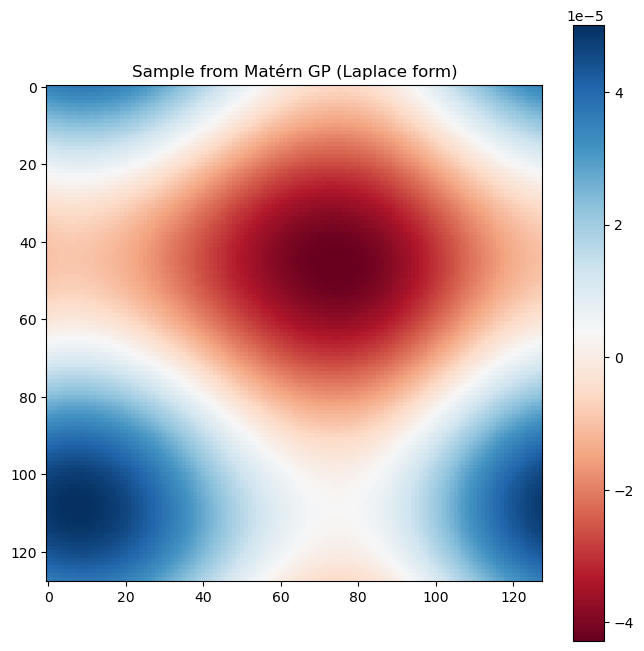

tensor(3.9329e-10)

In [2]:
# generating Gaussian measure on torus; diagonizable in Fourier

def generate_matern_laplace(num_samples, grid_size, sigma_sq=1.0, length_scale=1.0, s=2.0, seed=None):
    """
    Generate Matérn GP using the operator form σ²(-Δ + l²I)^{-s}
    
    Args:
        grid_size (int): Size of the grid (N x N)
        sigma_sq (float): Variance parameter σ²
        length_scale (float): Length scale l
        s (float): Smoothness parameter s
        seed (int): Random seed for reproducibility
    
    Returns:
        torch.Tensor: Sample from the GP
    """
    if seed is not None:
        torch.manual_seed(seed)
    
    # Generate frequency grid (scaled by 2π)
    freq = torch.fft.fftfreq(grid_size) * 2 * math.pi * grid_size
    freq_x, freq_y = torch.meshgrid(freq, freq, indexing='ij')
    
    # Compute -Laplacian in Fourier space: |k|²
    laplacian = freq_x**2 + freq_y**2
    
    # Compute spectral density: σ²(|k|² + l²)^{-s}
    spectral_density = sigma_sq * (laplacian + length_scale**2)**(-s)
    spectral_density[0,0] = 0
    spectral_density = spectral_density.unsqueeze(0)  # adding 1 dim
    
    # Generate complex Gaussian noise
    noise_real = torch.randn(num_samples, grid_size, grid_size)
    noise_imag = torch.randn(num_samples, grid_size, grid_size)
    noise = noise_real + 1j * noise_imag
    
    # Apply sqrt of spectral density
    spectral_sample = torch.sqrt(spectral_density) * noise
    
    # Transform back to spatial domain
    sample = torch.fft.ifft2(spectral_sample, norm='forward')
    sample = sample.real
    
    return sample

def plot_sample(sample):
    """Plot a sample from the GP"""
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(8, 8))
    plt.imshow(sample.numpy(), cmap='RdBu')
    plt.colorbar()
    plt.title('Sample from Matérn GP (Laplace form)')
    plt.show()

# Example usage

grid_size = 128
sample = generate_matern_laplace(
    num_samples=1000,
    grid_size=grid_size,
    sigma_sq=0.01,
    length_scale=1.0,
    s=5,
    seed=42
)

# Plot the sample
plot_sample(sample[0,...])
# (sample[:,...]**2).mean()

spatial_variance = (sample**2).mean(dim=(1, 2))
spatial_variance.mean()

In [3]:
#### standard interpolants

# base
ls0 = 1
s0 = 0
sigma_sq0 =  ((2*np.pi)**2 + ls0**2)**s0
param0 = [sigma_sq0, ls0, s0]

# target
ls1 = 1
s1 = 3
sigma_sq1 = 1 * ((2*np.pi)**2 + ls1**2)**s1
param1 = [sigma_sq1, ls1, s1]

grid_size = 128
freq = torch.fft.fftfreq(grid_size) * 2 * math.pi * grid_size
freq_x, freq_y = torch.meshgrid(freq, freq, indexing='ij')
laplacian = freq_x**2 + freq_y**2
# Compute spectral density: σ²(|k|² + l²)^{-s}
spectral_density0 = sigma_sq0 * (laplacian + ls0**2)**(-s0)
spectral_density1 = sigma_sq1 * (laplacian + ls1**2)**(-s1)
ratio = spectral_density1[grid_size//2,grid_size//2]/spectral_density0[grid_size//2,grid_size//2]



# ratio = np.exp(1)
print(ratio)


# scalar interpolant
def alpha(t):
    return np.sqrt((ratio - ratio**t)/(ratio - 1))

def alpha_dot(t):
    return -0.5*1/alpha(t)*(ratio**t)*np.log(ratio)/(ratio - 1)
    
def beta(t):
    return np.sqrt((ratio**t - 1)/(ratio - 1))

def beta_dot(t):
    return 0.5*1/beta(t)*(ratio**t)*np.log(ratio)/(ratio - 1)


tensor(1.9607e-12)


/state/partition1/job-63539340/ipykernel_3607269/4007284783.py:32: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return np.sqrt((ratio - ratio**t)/(ratio - 1))
/state/partition1/job-63539340/ipykernel_3607269/4007284783.py:38: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return np.sqrt((ratio**t - 1)/(ratio - 1))


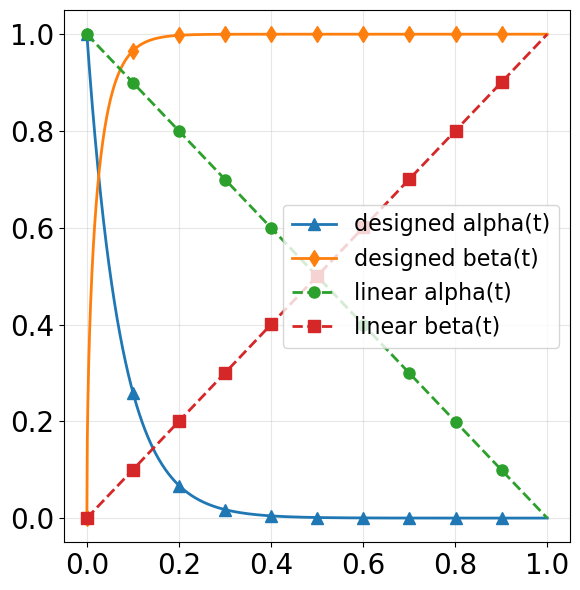

In [13]:
### show figures of alpha, beta

tmp_t = np.linspace(0,1,1000)
alpha_t = [alpha(t) for t in tmp_t]
markers = ['o', 's', '^', 'd', 'v']
plt.figure(figsize=(6, 6))

plt.plot(tmp_t, alpha_t, label="designed alpha(t)", marker=markers[2], markersize=8, markevery=100, linewidth=2)
beta_t = [beta(t) for t in tmp_t]
plt.plot(tmp_t, beta_t, label="designed beta(t)", marker=markers[3], markersize=8, markevery=100, linewidth=2)
plt.plot(tmp_t, [1-t for t in tmp_t], '--', label="linear alpha(t)", marker=markers[0], markersize=8, markevery=100, linewidth=2)
plt.plot(tmp_t, [t for t in tmp_t], '--', label="linear beta(t)", marker=markers[1], markersize=8, markevery=100, linewidth=2)



# plt.xlabel("t", fontsize=12)
plt.legend(fontsize=16)
plt.grid(alpha=0.3)
plt.tick_params(axis='both', which='major', labelsize=20)  # Change 14 to your desired size

plt.tight_layout()
plt.savefig(f"Gaussian-res128-designed-schedule.pdf", dpi=300)

In [5]:
# torch.save(Abins_w2, "Gaussian-res128-scaled-schedule-RK20.pt")

In [6]:
# torch.save(Abins_w1, "Gaussian-res128-truth.pt")
# torch.save(kvals, "Gaussian-res128-kvals.pt")
# torch.save(Abins_w0, "Gaussian-res128-init.pt")

In [33]:
res = 32
home = "/home/yc3400/scratch_research/gitrepo/GenerativeDynamics-NumericalDesign/Gaussian-fields/results/"
arrk = torch.load(home + f"Gaussian-res{res}-kvals.pt")
# arrinit = torch.load(home + f"Gaussian-res{res}-init.pt")
arrtruth = torch.load(home + f"Gaussian-res{res}-truth.pt")
arrRK20 = torch.load(home + f"Gaussian-res{res}-standard-schedule-RK20.pt") 
arrRK40 = torch.load(home + f"Gaussian-res{res}-standard-schedule-RK40.pt") 
arrRK80 = torch.load(home + f"Gaussian-res{res}-standard-schedule-RK80.pt")
arrscaledRK20 = torch.load(home + f"Gaussian-res{res}-scaled-schedule-RK20.pt")



/state/partition1/job-63539340/ipykernel_3607269/1240260235.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  arrk = torch.load(home + f"Gaussian-res{res}-kvals.pt")
/stat

/state/partition1/job-63539340/ipykernel_3607269/3933171291.py:4: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(arrk, arrtruth, 'o-', marker=markers[0], markersize=8, markevery=5, linestyle='-', label="truth", linewidth=2)
/state/partition1/job-63539340/ipykernel_3607269/3933171291.py:4: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(arrk, arrtruth, 'o-', marker=markers[0], markersize=8, markevery=5, linestyle='-', label="truth", linewidth=2)
/state/partition1/job-63539340/ipykernel_3607269/3933171291.py:5: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(arrk, arrscaledRK20, 'o-', marker=markers[4], mar

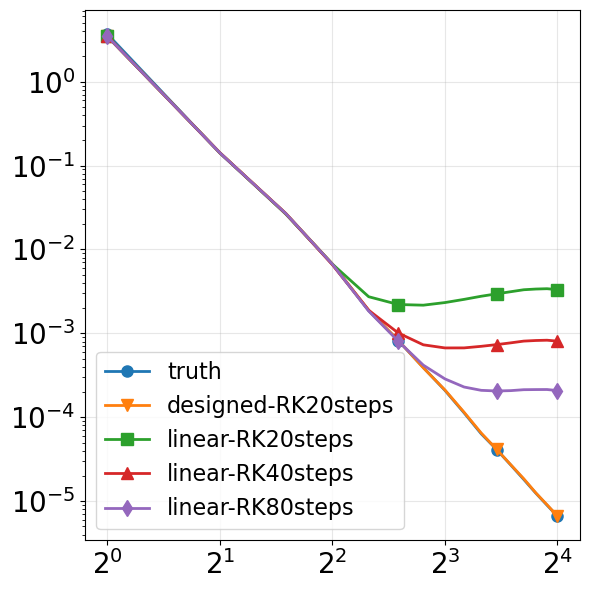

In [34]:

plt.figure(figsize=(6, 6))
markers = ['o', 's', '^', 'd', 'v']

plt.plot(arrk, arrtruth, 'o-', marker=markers[0], markersize=8, markevery=5, linestyle='-', label="truth", linewidth=2)
plt.plot(arrk, arrscaledRK20, 'o-', marker=markers[4], markersize=8, markevery=5, linestyle='-', label="designed-RK20steps", linewidth=2)
plt.plot(arrk, arrRK20, 'o-', marker=markers[1], markersize=8, markevery=5, linestyle='-', label="linear-RK20steps", linewidth=2)
plt.plot(arrk, arrRK40, 'o-', marker=markers[2], markersize=8, markevery=5, linestyle='-', label="linear-RK40steps", linewidth=2)
plt.plot(arrk, arrRK80, 'o-', marker=markers[3], markersize=8, markevery=5, linestyle='-', label="linear-RK80steps", linewidth=2)
# plt.plot(arrk, arrinit, 'o-', linestyle='-', label="init noise", linewidth=2)



plt.legend(fontsize=16, loc='lower left')
plt.grid(alpha=0.3)
plt.xscale('log', base = 2)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=20)  # Change 14 to your desired size
plt.locator_params(axis='x', numticks=5)  # Adjust number as needed

plt.tight_layout()
plt.savefig(f"Gaussian-res{res}-energy spectrum.pdf", dpi=300)

In [11]:
arrRK20

array([3.52919804e+00, 1.41089692e-01, 2.63145282e-02, 6.72828848e-03,
       2.69708664e-03, 2.19807135e-03, 2.16332432e-03, 2.35050396e-03,
       2.53421714e-03, 2.75759685e-03, 2.97557096e-03, 3.16104016e-03,
       3.30537746e-03, 3.38000011e-03, 3.39812614e-03, 3.32258507e-03,
       3.12253824e-03, 2.85420862e-03, 2.54485513e-03, 2.21717216e-03,
       1.85480758e-03, 1.47964698e-03, 1.15325035e-03, 9.09341706e-04,
       6.93099637e-04, 5.19795652e-04, 3.92363067e-04, 2.96174758e-04,
       2.23603709e-04, 1.69663535e-04, 1.28542074e-04, 1.00261943e-04,
       7.91414370e-05, 6.17897289e-05, 4.87985694e-05, 3.95250971e-05,
       3.23485169e-05, 2.70311393e-05, 2.26698560e-05, 1.93044126e-05,
       1.66897006e-05, 1.46943508e-05, 1.29270696e-05, 1.16588709e-05,
       1.07063274e-05, 9.92181992e-06, 9.19442860e-06, 8.59541475e-06,
       8.10168012e-06, 7.73747713e-06, 7.27191249e-06, 6.91407687e-06,
       6.68444508e-06, 6.51537071e-06, 6.37600368e-06, 6.25218914e-06,
      

In [24]:
arrtruth

array([3.53331149e+00, 1.36540403e-01, 2.68034322e-02, 6.65335971e-03,
       1.85453814e-03, 8.27667994e-04, 3.89742396e-04, 2.07077318e-04,
       1.12947180e-04, 6.38472449e-05, 4.09972000e-05, 2.70709281e-05,
       1.82327685e-05, 1.24241914e-05, 8.91048246e-06, 6.49448495e-06,
       4.66458063e-06, 3.49210096e-06, 2.68242069e-06, 2.11638406e-06,
       1.65845207e-06, 1.31543023e-06, 1.04351920e-06, 8.49641443e-07,
       6.90329925e-07, 5.60515602e-07, 4.68836604e-07, 3.90804589e-07,
       3.27770781e-07, 2.76655754e-07, 2.35229844e-07, 2.02839705e-07])